
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# To ease the loading of modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load BEACS module
from beacs.agents.beacs import BEACS, Configuration

# Load Metrics
from example.metrics.MazeMetrics import \
    _maze_metrics, \
    _how_many_peps_match_non_aliased_states, \
    _mean_reliable_classifier_specificity, \
    _when_full_knowledge_is_achieved, \
    _enhanced_effect_error

# Load Plotting Wrappers
from example.metrics.MazePlottingWrapper import \
    parse_metrics_to_df, \
    plot_performance

# Load environments
import gym
import my_mazes

# Agent - BEACS

## Common parameters

In [2]:
#Environmental Set Up
RANDOM_ATTRIBUTE_LENGTH = 0
CLASSIFIER_LENGTH = 8 + RANDOM_ATTRIBUTE_LENGTH
NUMBER_OF_POSSIBLE_ACTIONS = 8
SLIPPERY_PROB = 0.25
MAZE = "MazeE2-v0"

#Exploration Set Up
NUMBER_OF_EXPLORE_TRIALS = 5000
METRICS_TRIAL_FREQUENCY_EXPLORE = 100
EPSILON = 0.8
BETA_ALP = 0.05

#Exploitation Set Up
NUMBER_OF_EXPLOIT_TRIALS_NO_RL = 500
BETA_EXPLOIT_NO_RL = 0.05
NUMBER_OF_EXPLOIT_TRIALS_RL_START = 500
BETA_EXPLOIT_RL_START = 0.05
NUMBER_OF_EXPLOIT_TRIALS_RL = 500
BETA_EXPLOIT_RL = 0.05

#RL Set Up
GAMMA = 0.95
BETA_RL = 0.05

#GA Set Up
CROSSOVER = 0.8
MUTATION = 0.3

#BEACS Set Up
DO_ZIP = True
ENABLE_PEP = True
LENGTH_OF_BEHAVIORAL_SEQUENCES = 2

## Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Set up probability to do a random action
maze.env.set_prob_slippery(SLIPPERY_PROB)
# Set up random attribute length
maze.env.set_random_attribute_length(RANDOM_ATTRIBUTE_LENGTH)
# Reset it, by putting an agent into random position
maze.reset()
# Render the state in ASCII
maze.render('aliasing_human')
# Get environmental state transitions
#maze.env.get_theoritical_probabilities()


■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ ■ ■ A ■ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■
■ ■ ■ □ □ □ ■ ■ ■
■ ■ ■ □ $ □ ■ ■ ■
■ ■ ■ □ □ □ ■ ■ ■
■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ ■ ■ ■ ■ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■


## Training of BEACS - Exploration

In [4]:
%%time
#%%prun -l 0.5 -T profiling.txt

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_pep=ENABLE_PEP,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    gamma=GAMMA,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    mu=MUTATION,
    chi=CROSSOVER,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 15min 55s, sys: 4.7 s, total: 16min
Wall time: 16min 16s


### Performance

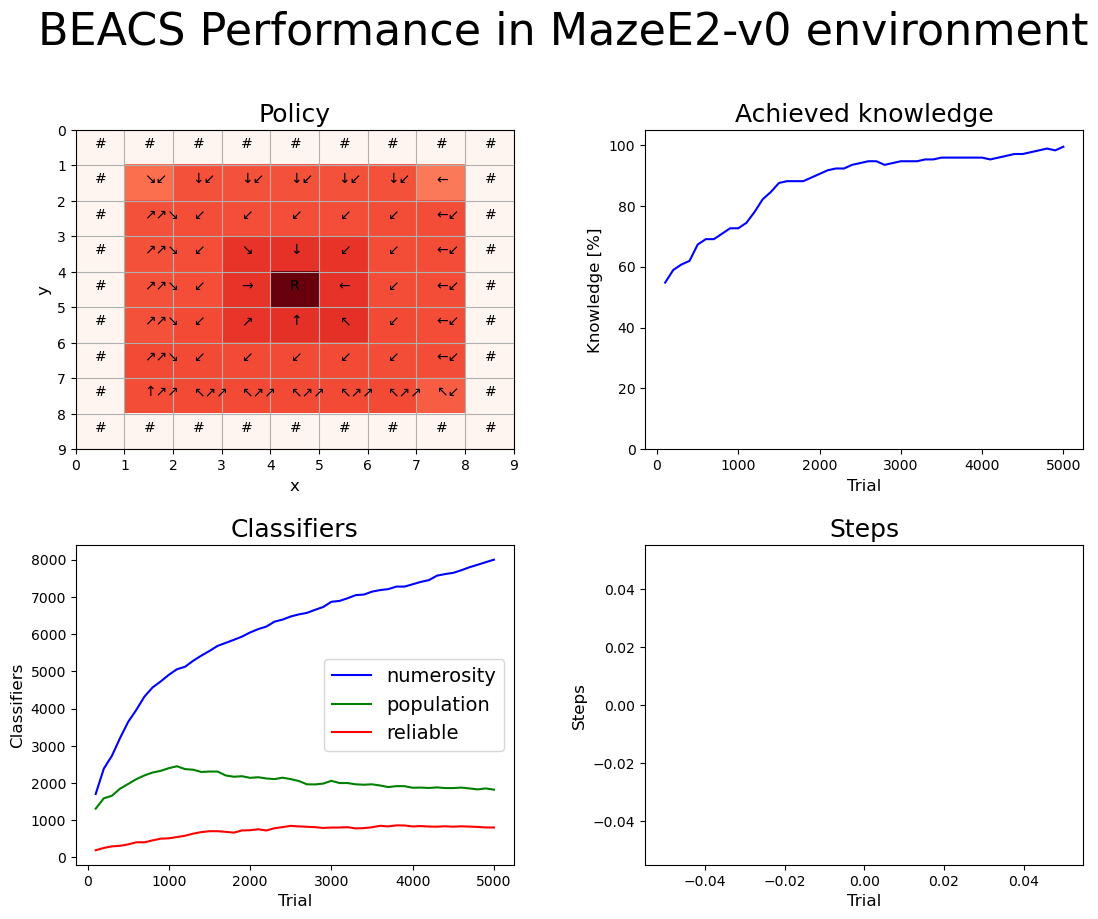

In [5]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_performance(agent_explore, maze, metrics_df, cfg_explore, MAZE, metrics_trial_frequency_explore, None)

In [6]:
first_trial, stable_trial, last_trial = _when_full_knowledge_is_achieved(metrics_explore)
print("Full knowledge was achieved at trials ", first_trial, ", was stable at ", stable_trial, 
        " and the last time it was achieved at ", last_trial)

print("There are ", _how_many_peps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.\n")

print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))
pep_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities :", pep_error, "%\n")

if DO_ZIP:
    agent_explore.zip_population()
    population_explore = agent_explore.get_population()

print("There are ", _how_many_peps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.\n")

print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))
pep_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities :", pep_error, "%")

Full knowledge was achieved at trials  -1 , was stable at  -1  and the last time it was achieved at  -1
There are  327  enhanced classifer(s) that match a non-aliased states.

{'knowledge': 99.40476190476191, 'population': 1820, 'numerosity': 7999, 'reliable': 804}
Mean reliable population specifity is  0.8328669154228856
Accumulated Error on PEP Probabilities : 2.8729876948824047 %

There are  173  enhanced classifer(s) that match a non-aliased states.

{'knowledge': 99.40476190476191, 'population': 489, 'numerosity': 4640, 'reliable': 377}
Mean reliable population specifity is  0.7519893899204244
Accumulated Error on PEP Probabilities : 2.873938888981694 %


In [7]:
population_explore.sort(key=lambda cl: -cl.fitness)
population_explore_to_display = [cl for cl in population_explore]
for cl in population_explore_to_display:
    print(cl)
    print("\n")

900###00 0 None (0#####9#:19, 0#######:340, 0######9:8, 09######:14, 0#9#####:10)
q: 1.0    ra: 983.0  rb: 971.1  ir: 854.5  f: 983.0  err: 40.53 
exp: 288   num: 18 ee: False
Mark: empty Aliased_state: 90000000 PAI_state: 
tga: 134678 tbseq: 133784 talp: 134678 tav: 330.8  



0#####09 7 None (#######0:383, 9######0:13, ######90:14)
q: 1.0    ra: 974.2  rb: 976.7  ir: 896.2  f: 976.7  err: 44.0  
exp: 402   num: 17 ee: False
Mark: empty Aliased_state: 00000009 PAI_state: 
tga: 134702 tbseq: 134501 talp: 134702 tav: 351.0  



##00900# 4 None (####0###:289, ####0#9#:7, ##9#0###:10, ###90###:8, ####09##:10)
q: 1.0    ra: 975.6  rb: 973.3  ir: 819.6  f: 975.6  err: 41.79 
exp: 212   num: 15 ee: False
Mark: empty Aliased_state: 00009000 PAI_state: 
tga: 134362 tbseq: 134300 talp: 134362 tav: 503.3  



0###0090 6 None (######0#:236, ######09:10, 9#####0#:8, ####9#0#:6, #####90#:11)
q: 1.0    ra: 974.8  rb: 954.8  ir: 736.9  f: 974.8  err: 52.5  
exp: 261   num: 19 ee: False
Mark: empty Al

In [8]:
agent_explore.get_pai_states_memory()

[('0', '0', '0', '0', '0', '0', '0', '0'),
 ('0', '1', '1', '1', '0', '0', '0', '0'),
 ('0', '0', '0', '0', '0', '1', '1', '1'),
 ('1', '1', '0', '0', '0', '0', '0', '1'),
 ('0', '0', '0', '1', '1', '1', '0', '0')]

## Training of BEACS - Exploitation

In [9]:
%%time

cfg_exploit_no_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_NO_RL,
    gamma=GAMMA,
    epsilon=0.2
)

agent_exploit_no_rl = BEACS(cfg_exploit_no_rl, population_explore)
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_NO_RL)

CPU times: user 17.5 s, sys: 101 ms, total: 17.6 s
Wall time: 18 s


In [10]:
%%time

cfg_exploit_rl_start = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_RL_START,
    gamma=GAMMA,
    epsilon=0.0
)

agent_exploit_rl_start = BEACS(cfg_exploit_rl_start, population_exploit_no_rl)
population_exploit_rl_start, metrics_exploit_rl_start = agent_exploit_rl_start.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL_START)

CPU times: user 17.6 s, sys: 161 ms, total: 17.8 s
Wall time: 18.3 s


In [11]:
%%time

cfg_exploit_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_RL,
    gamma=GAMMA,
    epsilon=0.0,
)

agent_exploit_rl = BEACS(cfg_exploit_rl, population_exploit_rl_start)
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 16.7 s, sys: 93.2 ms, total: 16.8 s
Wall time: 17.1 s


### Performance

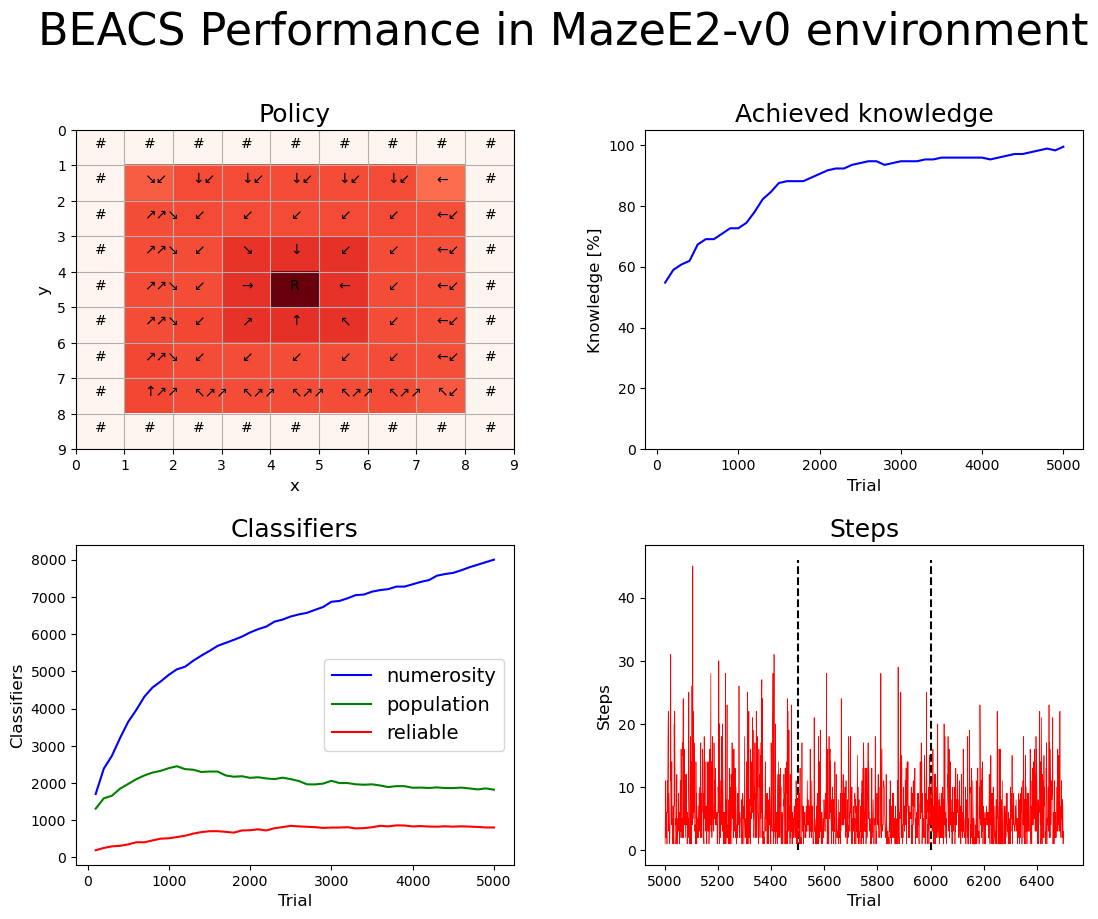

In [12]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    metrics_exploit.append(tmp)
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL + NUMBER_OF_EXPLOIT_TRIALS_RL_START
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit, metrics_trial_frequency_exploit)
plot_performance(agent_exploit_rl, maze, metrics_df, cfg_exploit_rl, MAZE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_NO_RL,NUMBER_OF_EXPLOIT_TRIALS_RL_START,NUMBER_OF_EXPLOIT_TRIALS_RL])

In [13]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / metrics_trial_frequency_explore
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

avg_step_exploit_no_rl = 0
for trial in metrics_exploit_no_rl:
    avg_step_exploit_no_rl += trial['steps_in_trial']
avg_step_exploit_no_rl /= NUMBER_OF_EXPLOIT_TRIALS_NO_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_no_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_NO_RL, " trials in EXPLOITATION without Reinforcement Module")

avg_step_exploit_rl_start = 0
for trial in metrics_exploit_rl_start:
    avg_step_exploit_rl_start += trial['steps_in_trial']
avg_step_exploit_rl_start /= NUMBER_OF_EXPLOIT_TRIALS_RL_START
print("Average number of steps to solve the maze is ",avg_step_exploit_rl_start,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL_START, " trials in EXPLOITATION starting Reinforcement Module")

avg_step_exploit_rl = 0
for trial in metrics_exploit_rl:
    avg_step_exploit_rl += trial['steps_in_trial']
avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")

print(_maze_metrics(population_explore, maze))
print(_maze_metrics(population_exploit_no_rl, maze))
print(_maze_metrics(population_exploit_rl_start, maze))
print(_maze_metrics(population_exploit_rl, maze))

Average number of steps to solve the maze is  30.1  for a total of  5000  trials in EXPLORATION
Average number of steps to solve the maze is  7.382  for a total of  500  trials in EXPLOITATION without Reinforcement Module
Average number of steps to solve the maze is  5.818  for a total of  500  trials in EXPLOITATION starting Reinforcement Module
Average number of steps to solve the maze is  5.994  for a total of  500  trials in EXPLOITATION with Reinforcement Module
{'knowledge': 99.40476190476191, 'population': 489, 'numerosity': 4640, 'reliable': 377}
{'knowledge': 99.40476190476191, 'population': 489, 'numerosity': 4640, 'reliable': 377}
{'knowledge': 99.40476190476191, 'population': 489, 'numerosity': 4640, 'reliable': 377}
{'knowledge': 99.40476190476191, 'population': 489, 'numerosity': 4640, 'reliable': 377}


In [14]:
population_exploit_rl.sort(key=lambda cl: -cl.fitness)
population_exploit_rl_to_display = [cl for cl in population_exploit_rl
    if cl.behavioral_sequence]
print(len(population_exploit_rl_to_display))
print("\n")
for cl in population_exploit_rl_to_display:
    print(cl)
    print("\n")

181


00#11111 0 [1, 1] (##900000:103, ###00000:66, #9#00000:22, ###00###:15, ######00:4, ########:4, 9##00000:3)
q: 0.9959 ra: 883.7  rb: 881.3  ir: 23.82  f: 877.7  err: 52.03 
exp: 48    num: 18 ee: False
Mark: empty Aliased_state: 00011111 PAI_state: 00000111
tga: 134453 tbseq: 118642 talp: 134453 tav: 293.6  



11000001 4 [5] (00###9#0:98, 00#####0:304, 00##9##0:116, 00#9###0:97, 00###11#:145, 0#11###0:9, ########:68, ##11####:4, #####11#:11)
q: 1.0    ra: 866.2  rb: 861.6  ir: 0.0    f: 863.9  err: 48.34 
exp: 758   num: 20 ee: False
Mark: empty Aliased_state: 11000001 PAI_state: 00000000
tga: 134262 tbseq: 16741 talp: 134348 tav: 173.5  



00011100 7 [1, 1] (###000##:143, ###000#9:10, #11#00##:35, ###00#11:7, ##9000##:52, ###0009#:32, 9##000##:23, ########:6, #11#####:1, #9#000##:8, ######11:2)
q: 0.9995 ra: 854.8  rb: 867.8  ir: 116.8  f: 854.4  err: 68.71 
exp: 91    num: 20 ee: False
Mark: empty Aliased_state: 00011100 PAI_state: 00000111
tga: 134633 tbseq: 128768 talp: 134